In [1]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetB6

2024-02-08 16:27:34.362783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 16:27:34.385635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 16:27:34.385653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 16:27:34.386254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 16:27:34.391342: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Cell 2: Define constants
BATCH_SIZE = 32
# IMG_HEIGHT = 380 efficientnetv2L
# IMG_WIDTH = 380
# IMG_HEIGHT = 300 #EfficientNetV2B3
# IMG_WIDTH = 300
IMG_HEIGHT = 528 #EfficientNetB6
IMG_WIDTH = 528
DATA_DIR = "/home/anon/MajorProject/Data/Dataset_alpha"

In [3]:
# Cell 3: Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 1500 files belonging to 16 classes.
Using 1200 files for training.


2024-02-08 16:27:41.472070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 16:27:41.490346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 16:27:41.490371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 16:27:41.492969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 16:27:41.492992: I external/local_xla/xla/stream_executor

Found 1500 files belonging to 16 classes.
Using 300 files for validation.
['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Neutral', 'Nothing', 'Play', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']


In [4]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        layers.RandomWidth(0.2),
        # layers.RandomTranslation(0.2, 0.2),
        layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH)
    ]
)

In [5]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [6]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

165234480/165234480 [==============================] - 12s 0us/step


2024-02-08 16:28:08.191620: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:28:08.191640: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:28:08.191649: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:28:08.191655: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:28:08.191732: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08

In [9]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='/home/anon/MajorProject/model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 528, 528, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 528, 528, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 528, 528, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 528, 528, 3)          0         ['normalization[0][

In [12]:
# Cell 7: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# checkpoint_filepath = '..\Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.keras'
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [13]:
#Cell 8 train the model
epochs = 30
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30


2024-02-08 16:31:12.459701: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:31:12.973116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:31:13.261650: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:31:13.261684: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-08 16:31:13.263936: W tensorflow/compiler/mlir/tools/k

 1/38 [..............................] - ETA: 9:51 - loss: 4.7014 - accuracy: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.1875

2024-02-08 16:31:16.626288: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


38/38 [==============================] - 60s 1s/step - loss: 3.6251 - accuracy: 0.1083 - sparse_categorical_accuracy: 0.1083 - sparse_top_k_categorical_accuracy: 0.4025 - val_loss: 2.6641 - val_accuracy: 0.1100 - val_sparse_categorical_accuracy: 0.1100 - val_sparse_top_k_categorical_accuracy: 0.5633
Epoch 2/30


2024-02-08 16:32:01.061690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:32:01.679477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 2.7263 - accuracy: 0.2292 - sparse_categorical_accuracy: 0.2292 - sparse_top_k_categorical_accuracy: 0.6117

2024-02-08 16:32:39.202234: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 2.7263 - accuracy: 0.2292 - sparse_categorical_accuracy: 0.2292 - sparse_top_k_categorical_accuracy: 0.6117 - val_loss: 2.5284 - val_accuracy: 0.4467 - val_sparse_categorical_accuracy: 0.4467 - val_sparse_top_k_categorical_accuracy: 0.7500
Epoch 3/30


2024-02-08 16:32:43.536334: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:32:44.144908: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 2.2920 - accuracy: 0.3300 - sparse_categorical_accuracy: 0.3300 - sparse_top_k_categorical_accuracy: 0.7300

2024-02-08 16:33:21.627352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 2.2920 - accuracy: 0.3300 - sparse_categorical_accuracy: 0.3300 - sparse_top_k_categorical_accuracy: 0.7300 - val_loss: 2.3758 - val_accuracy: 0.6100 - val_sparse_categorical_accuracy: 0.6100 - val_sparse_top_k_categorical_accuracy: 0.8867
Epoch 4/30


2024-02-08 16:33:25.987568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:33:26.595653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.8188 - accuracy: 0.4642 - sparse_categorical_accuracy: 0.4642 - sparse_top_k_categorical_accuracy: 0.8150

2024-02-08 16:34:04.179149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 1.8188 - accuracy: 0.4642 - sparse_categorical_accuracy: 0.4642 - sparse_top_k_categorical_accuracy: 0.8150 - val_loss: 2.2095 - val_accuracy: 0.6833 - val_sparse_categorical_accuracy: 0.6833 - val_sparse_top_k_categorical_accuracy: 0.9700
Epoch 5/30


2024-02-08 16:34:08.508363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:34:09.112352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.5217 - sparse_categorical_accuracy: 0.5217 - sparse_top_k_categorical_accuracy: 0.8525

2024-02-08 16:34:46.665977: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 1.6042 - accuracy: 0.5217 - sparse_categorical_accuracy: 0.5217 - sparse_top_k_categorical_accuracy: 0.8525 - val_loss: 2.0131 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200 - val_sparse_top_k_categorical_accuracy: 0.9800
Epoch 6/30


2024-02-08 16:34:51.002741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:34:51.608759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.5800 - sparse_categorical_accuracy: 0.5800 - sparse_top_k_categorical_accuracy: 0.8867

2024-02-08 16:35:29.269980: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 1.3827 - accuracy: 0.5800 - sparse_categorical_accuracy: 0.5800 - sparse_top_k_categorical_accuracy: 0.8867 - val_loss: 1.8035 - val_accuracy: 0.7633 - val_sparse_categorical_accuracy: 0.7633 - val_sparse_top_k_categorical_accuracy: 0.9933
Epoch 7/30


2024-02-08 16:35:33.612214: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:35:34.212906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.2615 - accuracy: 0.6333 - sparse_categorical_accuracy: 0.6333 - sparse_top_k_categorical_accuracy: 0.9117

2024-02-08 16:36:11.824964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 1.2615 - accuracy: 0.6333 - sparse_categorical_accuracy: 0.6333 - sparse_top_k_categorical_accuracy: 0.9117 - val_loss: 1.5796 - val_accuracy: 0.8067 - val_sparse_categorical_accuracy: 0.8067 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 8/30


2024-02-08 16:36:16.193149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:36:16.801847: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.1727 - accuracy: 0.6467 - sparse_categorical_accuracy: 0.6467 - sparse_top_k_categorical_accuracy: 0.9167

2024-02-08 16:36:54.324586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 1.1727 - accuracy: 0.6467 - sparse_categorical_accuracy: 0.6467 - sparse_top_k_categorical_accuracy: 0.9167 - val_loss: 1.3477 - val_accuracy: 0.8633 - val_sparse_categorical_accuracy: 0.8633 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 9/30


2024-02-08 16:36:58.655429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:36:59.268219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.6692 - sparse_categorical_accuracy: 0.6692 - sparse_top_k_categorical_accuracy: 0.9392

2024-02-08 16:37:36.788424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 1.0476 - accuracy: 0.6692 - sparse_categorical_accuracy: 0.6692 - sparse_top_k_categorical_accuracy: 0.9392 - val_loss: 1.1306 - val_accuracy: 0.8800 - val_sparse_categorical_accuracy: 0.8800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 10/30


2024-02-08 16:37:41.137991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:37:41.741383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.7167 - sparse_categorical_accuracy: 0.7167 - sparse_top_k_categorical_accuracy: 0.9475

2024-02-08 16:38:19.254989: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.9435 - accuracy: 0.7167 - sparse_categorical_accuracy: 0.7167 - sparse_top_k_categorical_accuracy: 0.9475 - val_loss: 0.9220 - val_accuracy: 0.9033 - val_sparse_categorical_accuracy: 0.9033 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 11/30


2024-02-08 16:38:23.589723: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:38:24.195462: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.7492 - sparse_categorical_accuracy: 0.7492 - sparse_top_k_categorical_accuracy: 0.9533

2024-02-08 16:39:01.720716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.8583 - accuracy: 0.7492 - sparse_categorical_accuracy: 0.7492 - sparse_top_k_categorical_accuracy: 0.9533 - val_loss: 0.7347 - val_accuracy: 0.9367 - val_sparse_categorical_accuracy: 0.9367 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 12/30


2024-02-08 16:39:06.050882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:39:06.652176: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7883 - sparse_categorical_accuracy: 0.7883 - sparse_top_k_categorical_accuracy: 0.9733

2024-02-08 16:39:44.157686: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.7300 - accuracy: 0.7883 - sparse_categorical_accuracy: 0.7883 - sparse_top_k_categorical_accuracy: 0.9733 - val_loss: 0.5867 - val_accuracy: 0.9633 - val_sparse_categorical_accuracy: 0.9633 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 13/30


2024-02-08 16:39:48.517770: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:39:49.123061: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.7825 - sparse_categorical_accuracy: 0.7825 - sparse_top_k_categorical_accuracy: 0.9683

2024-02-08 16:40:26.651418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.7350 - accuracy: 0.7825 - sparse_categorical_accuracy: 0.7825 - sparse_top_k_categorical_accuracy: 0.9683 - val_loss: 0.4793 - val_accuracy: 0.9667 - val_sparse_categorical_accuracy: 0.9667 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 14/30


2024-02-08 16:40:30.983732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:40:31.585856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7950 - sparse_categorical_accuracy: 0.7950 - sparse_top_k_categorical_accuracy: 0.9675

2024-02-08 16:41:09.078682: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.7169 - accuracy: 0.7950 - sparse_categorical_accuracy: 0.7950 - sparse_top_k_categorical_accuracy: 0.9675 - val_loss: 0.3819 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 15/30


2024-02-08 16:41:13.417747: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:41:14.021491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7767 - sparse_categorical_accuracy: 0.7767 - sparse_top_k_categorical_accuracy: 0.9733

2024-02-08 16:41:51.580510: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.7133 - accuracy: 0.7767 - sparse_categorical_accuracy: 0.7767 - sparse_top_k_categorical_accuracy: 0.9733 - val_loss: 0.3176 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 16/30


2024-02-08 16:41:55.929653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:41:56.532485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.8208 - sparse_categorical_accuracy: 0.8208 - sparse_top_k_categorical_accuracy: 0.9825

2024-02-08 16:42:34.068429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.5781 - accuracy: 0.8208 - sparse_categorical_accuracy: 0.8208 - sparse_top_k_categorical_accuracy: 0.9825 - val_loss: 0.2668 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 17/30


2024-02-08 16:42:38.418087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:42:39.021437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.8067 - sparse_categorical_accuracy: 0.8067 - sparse_top_k_categorical_accuracy: 0.9692

2024-02-08 16:43:16.530643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.6412 - accuracy: 0.8067 - sparse_categorical_accuracy: 0.8067 - sparse_top_k_categorical_accuracy: 0.9692 - val_loss: 0.2299 - val_accuracy: 0.9833 - val_sparse_categorical_accuracy: 0.9833 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 18/30


2024-02-08 16:43:20.893569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:43:21.495943: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8317 - sparse_categorical_accuracy: 0.8317 - sparse_top_k_categorical_accuracy: 0.9817

2024-02-08 16:43:59.188996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.5618 - accuracy: 0.8317 - sparse_categorical_accuracy: 0.8317 - sparse_top_k_categorical_accuracy: 0.9817 - val_loss: 0.2045 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 19/30


2024-02-08 16:44:03.602332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:44:04.218633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.8600 - sparse_categorical_accuracy: 0.8600 - sparse_top_k_categorical_accuracy: 0.9800

2024-02-08 16:44:41.931948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.5261 - accuracy: 0.8600 - sparse_categorical_accuracy: 0.8600 - sparse_top_k_categorical_accuracy: 0.9800 - val_loss: 0.1831 - val_accuracy: 0.9833 - val_sparse_categorical_accuracy: 0.9833 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 20/30


2024-02-08 16:44:46.316472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:44:46.921853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8358 - sparse_categorical_accuracy: 0.8358 - sparse_top_k_categorical_accuracy: 0.9875

2024-02-08 16:45:24.629929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.5241 - accuracy: 0.8358 - sparse_categorical_accuracy: 0.8358 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.1660 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 21/30


2024-02-08 16:45:29.010819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:45:29.615886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.8417 - sparse_categorical_accuracy: 0.8417 - sparse_top_k_categorical_accuracy: 0.9833

2024-02-08 16:46:07.333991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.5384 - accuracy: 0.8417 - sparse_categorical_accuracy: 0.8417 - sparse_top_k_categorical_accuracy: 0.9833 - val_loss: 0.1518 - val_accuracy: 0.9833 - val_sparse_categorical_accuracy: 0.9833 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 22/30


2024-02-08 16:46:11.711492: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:46:12.316659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8592 - sparse_categorical_accuracy: 0.8592 - sparse_top_k_categorical_accuracy: 0.9833

2024-02-08 16:46:50.100967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.4643 - accuracy: 0.8592 - sparse_categorical_accuracy: 0.8592 - sparse_top_k_categorical_accuracy: 0.9833 - val_loss: 0.1445 - val_accuracy: 0.9833 - val_sparse_categorical_accuracy: 0.9833 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 23/30


2024-02-08 16:46:54.481777: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:46:55.085807: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8800 - sparse_categorical_accuracy: 0.8800 - sparse_top_k_categorical_accuracy: 0.9900

2024-02-08 16:47:32.839445: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.4255 - accuracy: 0.8800 - sparse_categorical_accuracy: 0.8800 - sparse_top_k_categorical_accuracy: 0.9900 - val_loss: 0.1346 - val_accuracy: 0.9833 - val_sparse_categorical_accuracy: 0.9833 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 24/30


2024-02-08 16:47:37.228074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:47:37.837760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8658 - sparse_categorical_accuracy: 0.8658 - sparse_top_k_categorical_accuracy: 0.9875

2024-02-08 16:48:15.467425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.4418 - accuracy: 0.8658 - sparse_categorical_accuracy: 0.8658 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.1302 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 25/30


2024-02-08 16:48:19.803921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:48:20.411963: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.8708 - sparse_categorical_accuracy: 0.8708 - sparse_top_k_categorical_accuracy: 0.9867

2024-02-08 16:48:57.945172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.4392 - accuracy: 0.8708 - sparse_categorical_accuracy: 0.8708 - sparse_top_k_categorical_accuracy: 0.9867 - val_loss: 0.1231 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 26/30


2024-02-08 16:49:02.277568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:49:02.882017: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8908 - sparse_categorical_accuracy: 0.8908 - sparse_top_k_categorical_accuracy: 0.9908

2024-02-08 16:49:40.385615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.3785 - accuracy: 0.8908 - sparse_categorical_accuracy: 0.8908 - sparse_top_k_categorical_accuracy: 0.9908 - val_loss: 0.1136 - val_accuracy: 0.9800 - val_sparse_categorical_accuracy: 0.9800 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 27/30


2024-02-08 16:49:44.732397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:49:45.340584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.8900 - sparse_categorical_accuracy: 0.8900 - sparse_top_k_categorical_accuracy: 0.9892

2024-02-08 16:50:22.849979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.3999 - accuracy: 0.8900 - sparse_categorical_accuracy: 0.8900 - sparse_top_k_categorical_accuracy: 0.9892 - val_loss: 0.1017 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 28/30


2024-02-08 16:50:27.184305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:50:27.788062: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8975 - sparse_categorical_accuracy: 0.8975 - sparse_top_k_categorical_accuracy: 0.9900

2024-02-08 16:51:05.265128: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.3796 - accuracy: 0.8975 - sparse_categorical_accuracy: 0.8975 - sparse_top_k_categorical_accuracy: 0.9900 - val_loss: 0.0972 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 29/30


2024-02-08 16:51:09.591358: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:51:10.198948: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8950 - sparse_categorical_accuracy: 0.8950 - sparse_top_k_categorical_accuracy: 0.9925

2024-02-08 16:51:47.767647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 42s 1s/step - loss: 0.3408 - accuracy: 0.8950 - sparse_categorical_accuracy: 0.8950 - sparse_top_k_categorical_accuracy: 0.9925 - val_loss: 0.0962 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 30/30


2024-02-08 16:51:52.102191: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:51:52.711679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3259 - accuracy: 0.9075 - sparse_categorical_accuracy: 0.9075 - sparse_top_k_categorical_accuracy: 0.9967

2024-02-08 16:52:30.335599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.3259 - accuracy: 0.9075 - sparse_categorical_accuracy: 0.9075 - sparse_top_k_categorical_accuracy: 0.9967 - val_loss: 0.0876 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000


In [14]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetB6_FEB_8.h5')
# model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_without_onehot.keras')

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2024-02-08 16:53:28.276139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 3s 3s/step


2024-02-08 16:53:30.851543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 34ms/step


2024-02-08 16:53:31.599108: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 49ms/step


2024-02-08 16:53:32.094330: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 215ms/step


2024-02-08 16:53:32.756269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 218ms/step


2024-02-08 16:53:33.416002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 229ms/step


2024-02-08 16:53:34.093578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 244ms/step


2024-02-08 16:53:34.784504: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 249ms/step


2024-02-08 16:53:35.476638: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 32ms/step


2024-02-08 16:53:35.951875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 3s 3s/step


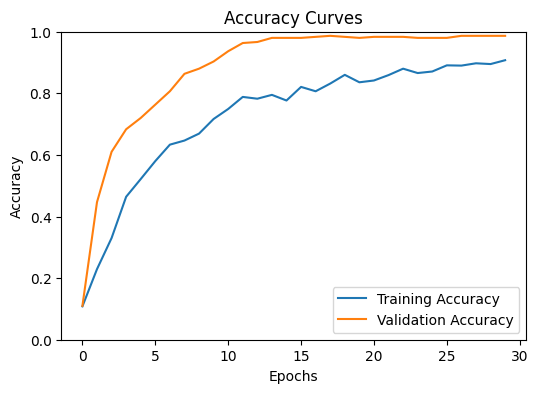

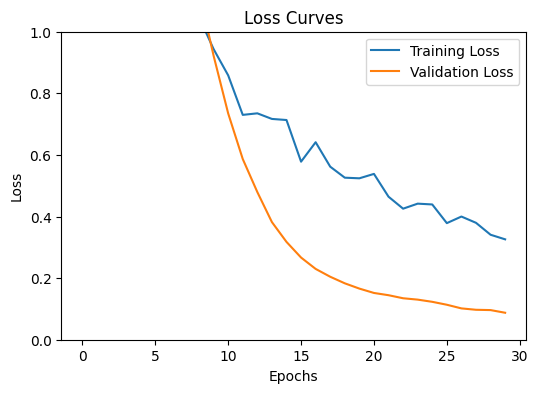

In [16]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [17]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# we chose to train the top 2 blocks, i.e. we will freeze
# the first 668 layers and unfreeze the rest:
for layer in model.layers[:668]:
   layer.trainable = False
for layer in model.layers[668:]:
   layer.trainable = True
# we need to recompile the model for these modifications to take effect
# we train our model again (this time fine-tuning the top 2 blocks
# alongside the top Dense layers
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/5


2024-02-08 16:54:12.982266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:54:13.628990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8908 - sparse_categorical_accuracy: 0.8908 - sparse_top_k_categorical_accuracy: 0.9917

2024-02-08 16:54:54.089285: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 57s 1s/step - loss: 0.3659 - accuracy: 0.8908 - sparse_categorical_accuracy: 0.8908 - sparse_top_k_categorical_accuracy: 0.9917 - val_loss: 0.0857 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 2/5


2024-02-08 16:54:58.495527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:54:59.105773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.9025 - sparse_categorical_accuracy: 0.9025 - sparse_top_k_categorical_accuracy: 0.9942

2024-02-08 16:55:36.931489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.3370 - accuracy: 0.9025 - sparse_categorical_accuracy: 0.9025 - sparse_top_k_categorical_accuracy: 0.9942 - val_loss: 0.0849 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/5


2024-02-08 16:55:41.236961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:55:41.840182: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8975 - sparse_categorical_accuracy: 0.8975 - sparse_top_k_categorical_accuracy: 0.9933

2024-02-08 16:56:19.653295: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.3448 - accuracy: 0.8975 - sparse_categorical_accuracy: 0.8975 - sparse_top_k_categorical_accuracy: 0.9933 - val_loss: 0.0845 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/5


2024-02-08 16:56:23.954696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:56:24.557887: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8950 - sparse_categorical_accuracy: 0.8950 - sparse_top_k_categorical_accuracy: 0.9875

2024-02-08 16:57:02.679660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.3597 - accuracy: 0.8950 - sparse_categorical_accuracy: 0.8950 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.0842 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/5


2024-02-08 16:57:06.987420: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-08 16:57:07.591901: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8967 - sparse_categorical_accuracy: 0.8967 - sparse_top_k_categorical_accuracy: 0.9933

2024-02-08 16:57:45.473373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


38/38 [==============================] - 43s 1s/step - loss: 0.3431 - accuracy: 0.8967 - sparse_categorical_accuracy: 0.8967 - sparse_top_k_categorical_accuracy: 0.9933 - val_loss: 0.0846 - val_accuracy: 0.9867 - val_sparse_categorical_accuracy: 0.9867 - val_sparse_top_k_categorical_accuracy: 1.0000


In [18]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2024-02-08 16:58:13.293889: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053184 bytes after encountering the first element of size 107053184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 3s 3s/step


2024-02-08 16:58:16.000079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 31ms/step


2024-02-08 16:58:16.695973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 30ms/step


2024-02-08 16:58:17.356380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 31ms/step


2024-02-08 16:58:17.833016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 33ms/step


2024-02-08 16:58:18.310502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 33ms/step


2024-02-08 16:58:18.789782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 33ms/step


2024-02-08 16:58:19.267454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 30ms/step


2024-02-08 16:58:19.741791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 30ms/step


2024-02-08 16:58:20.215702: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 107053056 bytes after encountering the first element of size 107053056 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 2s 2s/step


Accuracy: 0.9866666666666667
Precision: 0.9880784313725491
Recall: 0.9888157894736842
F1 Score: 0.9878702374927495
AUC-ROC: 0.9939308116146075


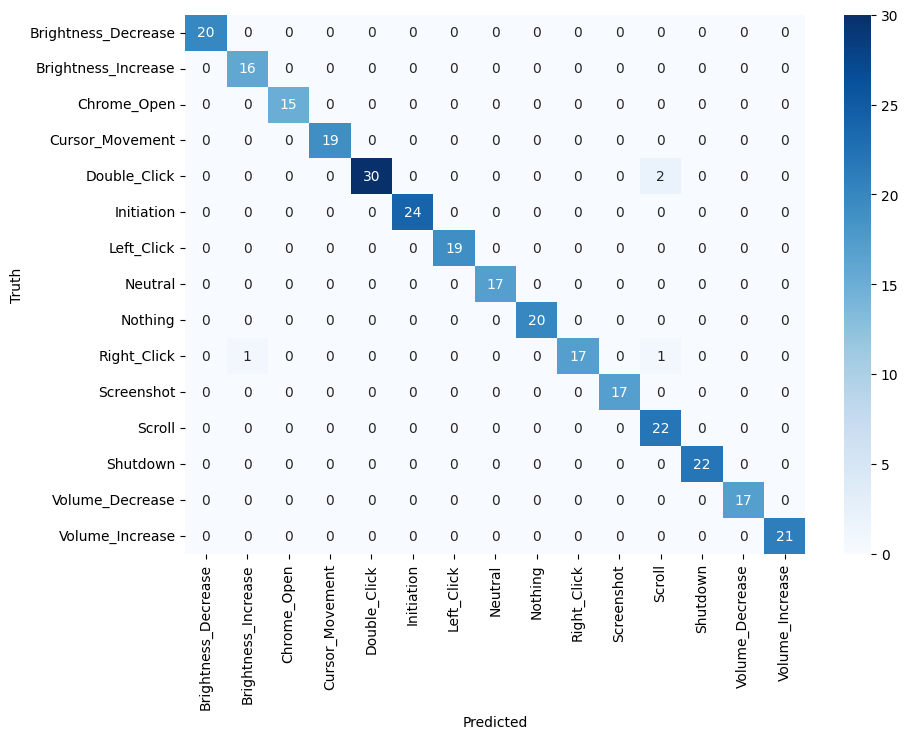

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
class_names = ["Brightness_Decrease", "Brightness_Increase", "Chrome_Open", "Cursor_Movement", "Double_Click", "Initiation", "Left_Click", "Neutral", "Nothing", "Right_Click", "Screenshot", "Scroll", "Shutdown", "Volume_Decrease", "Volume_Increase"]

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9939308116146075


In [24]:
# model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_without_onehot_finetuned.h5')
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetB6_FEB_8_finetuned.keras')

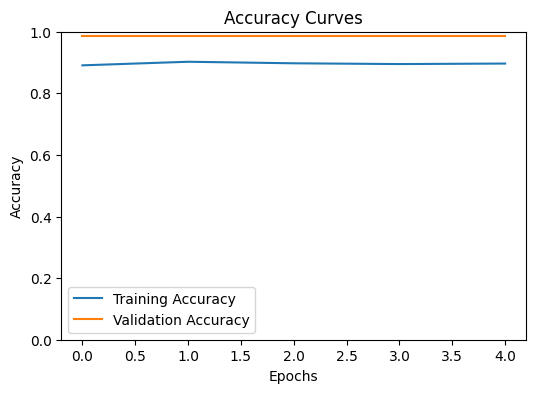

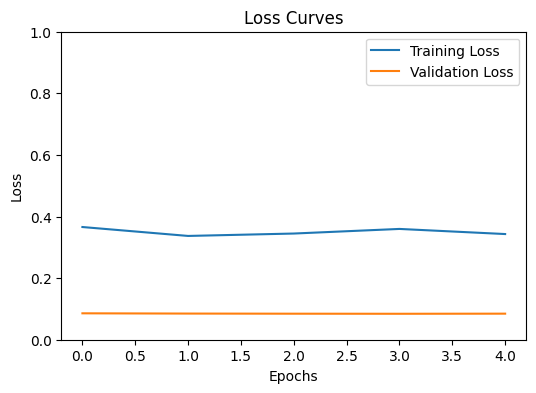

In [25]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
